In [1]:
import py_wgpu_fdm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation


In [2]:
# Given parameters
d = 5e-4    # winding wire diameter (m)
R = 8e-4    # core wire diameter (m)
alpha = 0.0318  # helix angle (radians)
L = 0.8       # total axial length (m)
N = 4096

kappa = (1/R) * np.cos(alpha)**2
tau = kappa * np.tan(alpha)

S = L / np.sin(alpha)


print(f"Curvature κ: {kappa:.3e} 1/m")
print(f"Torsion τ: {tau:.3e} 1/m")
print(f"Wire length S: {S:.3f} m")


Curvature κ: 1.249e+03 1/m
Torsion τ: 3.972e+01 1/m
Wire length S: 25.161 m


In [3]:
dt = 1e-6
ds = S/N

oversampling_factor = 128

ds

np.float64(0.006142937794111958)

In [4]:
def winding_properties(d, E, G, rho):

    r = d / 2
    A = np.pi * r**2
    I1 = I2 = (np.pi * r**4) / 4   # bending moments of inertia
    J = (np.pi * r**4) / 2         # polar moment of inertia for torsion

    # Radii of gyration
    k1 = np.sqrt(I1 / A)
    k2 = np.sqrt(I2 / A)
    kT = np.sqrt(J / A)

    # Flexural rigidities (bending about two axes) and torsional rigidity
    beta1 = E * I1
    beta2 = E * I2
    betaT = G * J

    # Shear rigidities (sigma1, sigma2) and extensional rigidity (sigma_p)
    sigma1 = G * A
    sigma2 = G * A
    sigma_p = E * A

    mass_per_length = rho * A

    return {
        'm': mass_per_length,
        'k': [k1, k2, kT],
        'beta': [beta1, beta2, betaT],
        'sigma': [sigma1, sigma2, sigma_p]
    }

In [5]:
loss = 0.999999990
rho = 8900
E=1.1e11
G=4.1e10

coil_props = winding_properties(d, E, G, rho)
print(coil_props)
print(tau, kappa)

{'m': 0.0017475109135593222, 'k': [np.float64(0.00012500000000000003), np.float64(0.00012500000000000003), np.float64(0.0001767766952966369)], 'beta': [0.00033747577333484115, 0.00033747577333484115, 0.0002515728492132452], 'sigma': [8050.331174823844, 8050.331174823844, 21598.449493429827]}
39.723207559291644 1248.736376028528


In [6]:

# Create initial node data in local (u,v,w) helical frame
nodes = []
for i in range(N):
    position = [0.0, 0.0, 0.0]  # along tangent
    velocity = [0.0, 0.0, 0.0]
    angle = [0.0, 0.0, 0.0]
    angular_velocity = [0.0, 0.0, 0.0]
    
    nodes.append([position, velocity, angle, angular_velocity])



In [7]:
# Initialize simulation with given parameters
sim = py_wgpu_fdm.Simulation(
    nodes,
    oversampling_factor,
    dt,
    ds,
    loss,
    tau,
    kappa,
    coil_props['m'],
    5000,
    coil_props['beta'],
    [1, 1, 1],
    coil_props['k']
)

# Run the initialization for 50 steps
sim.initialize(200)

# Run the simulation for a number of frames
n_frames = 200
steps = 50
ori_frames = []

total = oversampling_factor * steps *  n_frames

print(f'Running {total} steps, which is {total * dt} seconds.') 

for i in range(n_frames):
    for _ in range(steps):
        sim.compute()
    frame = sim.save()
    ori_frames.append(frame)


Running 1280000 steps, which is 1.28 seconds.


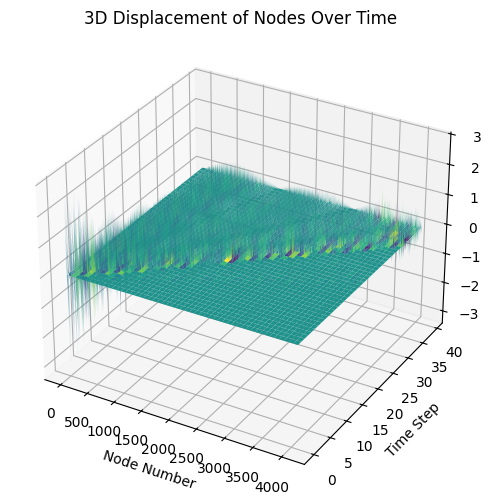

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assume frames is already defined as:
# frames[time_step][node_index][0][0] -> displacement value

frames = [ f for i,f in enumerate(ori_frames) if i % 5 == 0 ]


# Extract number of time steps and nodes
num_frames = len(frames)
num_nodes = len(frames[0])

# Build coordinate grids
time_steps = np.arange(num_frames)
node_indices = np.arange(num_nodes)
T, N = np.meshgrid(time_steps, node_indices, indexing='ij')

# Extract displacement values into a 2D array (time × nodes)
displacements = np.array([[frame[node][0][1] for node in range(num_nodes)] for frame in frames])

# Create 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(N, T, displacements, cmap='viridis', edgecolor='none')

# Axis labels
ax.set_xlabel('Node Number')
ax.set_ylabel('Time Step')
ax.set_zlabel('Displacement')

ax.set_title('3D Displacement of Nodes Over Time')

plt.show()


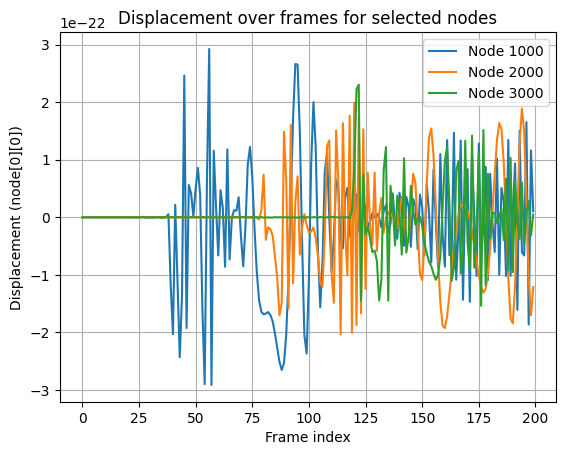

In [16]:
import matplotlib.pyplot as plt


frames = ori_frames

indices = [ 1000, 2000, 3000 ]

# Extract displacements
for i in indices:
    displacements = [frame[i][0][0] for frame in frames]
    plt.plot(range(len(frames)), displacements, label=f'Node {i}')

plt.xlabel('Frame index')
plt.ylabel('Displacement (node[0][0])')
plt.title('Displacement over frames for selected nodes')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
frames[-1]

[[[0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0]],
 [[0.0, 1.0742770669653124e-25, -3.3217071007120486e-24],
  [0.0, -2.9879746353751233e-22, 9.566102253899248e-21],
  [-4.361263331555739e-21, 0.0, -1.3878498063135472e-22],
  [-1.8626227626752156e-18, 0.0, -6.264872735255418e-20],
  [1.6475070966905159e-22, 0.0, 0.0],
  [0.0, -1.69978262808542e-26, 0.0]],
 [[-3.841693690377469e-25, 0.0, 0.0],
  [-9.591658418976729e-21, 0.0, 0.0],
  [0.0, 9.778205788936104e-26, 0.0],
  [0.0, 1.2582505618763011e-21, 0.0],
  [0.0, -1.3296028098724882e-23, 4.1956338434600457e-22],
  [-6.732725187416307e-25, 0.0, -4.2108134792142003e-26]],
 [[0.0, 1.270911987467162e-25, -3.957334536107047e-24],
  [0.0, 1.0971085689933863e-21, -3.4061420312684096e-20],
  [-4.385336387644306e-21, 0.0, -1.3933020342372003e-22],
  [-1.378161172478807e-18, 0.0, -3.2321691463423154e-20],
  [-4.294376004728667e-22, 0.0, 0.0],
  [0.0, 6.212035574772915e-26, 0.0]],
 [[7